This example emphasizes two scenarii not covered in the simple example:
- using charge passed over time data, which can be acquired when performing electrochemical measurements (chronocoulometry), and that can help improve the accuracy of the time constants obtained from the fit
- fitting when the concentration evolution over time experimental data only covers some of the species considered in the model

### Kinetic model

The kinetics model derived in [this paper](TODO add link when published) leads to the following set of differential equations:

$$\frac{d[HMF]}{dt} = -(k_{\textbf{1}1} + k_{\textbf{1}2} + k_{H\textbf{1}})[HMF]$$

$$\frac{d[DFF]}{dt} = k_{\textbf{1}1}[HMF] - (k_{\textbf{2}1} + k_{H\textbf{2}1})[DFF]$$

$$\frac{d[HMFCA]}{dt} = k_{\textbf{1}2}[HMF] - (k_{\textbf{2}2} + k_{H\textbf{2}2})[HMFCA]$$

$$\frac{d[FFCA]}{dt} = k_{\textbf{2}1}[DFF] + k_{\textbf{2}2}[HMFCA] - (k_{\textbf{3}} + k_{H\textbf{3}})[FFCA]$$

$$\frac{d[FDCA]}{dt} = k_{\textbf{3}}[FFCA] - k_{H\textbf{4}}[FDCA]$$

$$\frac{d[humins]}{dt} = k_{H\textbf{1}}[HMF] + k_{H\textbf{2}1}[DFF] + k_{H\textbf{2}2}[HMFCA]$$
$$+ k_{H\textbf{3}}[FFCA] + k_{H\textbf{4}}[FDCA] - k_{H^*}[humins]$$

$$\frac{d[humins^*]}{dt} = k_{H^*}[humins]$$

In order to write a function describing this model we need to define all the species whose concentrations evolution over time are considered in this study. In that case 5 species concentrations were tracked by HPLC measurements (HMF, DFF, HMFCA, FFCA, FDCA). The humins and electropolymerized humins (humins\*) concentrations could not be tracked. For the untracked species we need to consider 10 additional concentrations. Indeed, in the differential equations mentionned above only the total concentration evolution of humins and humins\* (electropolymerized humins) are considered. However, these total humins and humins\* concentrations need to be splitted here into the individual concentrations coming from each individual humins formation reactions. This is required because humins species formed through different reaction pathways will involve a different amount of charge passed in our electrochemical measurement. With these individual concentrations we are able to calculate the amount of charge passed over time allowing us to include the corresponding experimental data in the fit.

We define the species names considered in this experiment as follow:

In [1]:
species_tracked = [
    "HMF", "DFF", "HMFCA", "FFCA", "FDCA"
]
species_untracked = [
    "H_HMF",  "H_DFF",  "H_HMFCA",  "H_FFCA",  "H_FDCA",
    "Hx_HMF", "Hx_DFF", "Hx_HMFCA", "Hx_FFCA", "Hx_FDCA"
]
species = species_tracked.copy()
species.extend(species_untracked)

HMF, DFF, HMFCA, FFCA and FDCA are the species whose concentrations are tracked experimentally. The humins and humins\* coming from these species are denoted with the same names prepended respectively with a "H_" and a "Hx_". To sum up we can now write:

$$ [humins] = [H\_HMF] + [H\_DFF] + [H\_HMFCA] + [H\_FFCA] + [H\_FDCA] $$

$$ [humins^*] = [Hx\_HMF] + [Hx\_DFF] + [Hx\_HMFCA] + [Hx\_FFCA] + [Hx\_FDCA] $$

Therefore, the derivatives presented above for the concentration of humins are rewritten in the following way:

$$\frac{d[H\_HMF]}{dt} = k_{H\textbf{1}}[HMF] - k_{H^*}[H\_HMF]$$

$$\frac{d[H\_DFF]}{dt} = k_{H\textbf{1}}[DFF] - k_{H^*}[H\_DFF]$$

$$\frac{d[H\_HMFCA]}{dt} = k_{H\textbf{1}}[HMFCA] - k_{H^*}[H\_HMFCA]$$

$$\frac{d[H\_FFCA]}{dt} = k_{H\textbf{1}}[FFCA] - k_{H^*}[H\_FFCA]$$

$$\frac{d[H\_FDCA]}{dt} = k_{H\textbf{1}}[FDCA] - k_{H^*}[H\_FDCA]$$

The derivatives for the concentration of humins\* are rewritten in this way:

$$\frac{d[Hx\_HMF]}{dt} = k_{H^*}[H\_HMF]$$

$$\frac{d[Hx\_DFF]}{dt} = k_{H^*}[H\_DFF]$$

$$\frac{d[Hx\_HMFCA]}{dt} = k_{H^*}[H\_HMFCA]$$

$$\frac{d[Hx\_FFCA]}{dt} = k_{H^*}[H\_FFCA]$$

$$\frac{d[Hx\_FDCA]}{dt} = k_{H^*}[H\_FDCA]$$

We can now write the "derivatives" function derived from these differential equations:

In [2]:
def derivatives(y, t, p):

    """Calculates the derivatives of the concentrations at t
    
    Used scipy.integrate.odeint to numerically solve the differential
    equations in a given time range.
    
    Lists ("y" and "dy") used by scipy.integrate.odeint are converted
    to dictionaries ("c" and "dc") in order to make the differentials
    easier to write and read for humans.
    
    Arguments:
        y (list): concentration values at t
        t (float): time value where the derivatives are calculated
        p (dict): dictionary containing the parameters used to
        calculate the derivatives e.g. time constants
    """
    
    c = {s:y[i] for i, s in enumerate(species)}
    
    dc = dict()

    dc["HMF"]      =  - (p["k11"] + p["k12"] + p["kH1"])*c["HMF"]
    dc["DFF"]      = p["k11"]*c["HMF"]                       - (p["k21"] + p["kH21"])*c["DFF"]
    dc["HMFCA"]    = p["k12"]*c["HMF"]                       - (p["k22"] + p["kH22"])*c["HMFCA"]
    dc["FFCA"]     = p["k21"]*c["DFF"] + p["k22"]*c["HMFCA"] - (p["k3"] + p["kH3"])*c["FFCA"]
    dc["FDCA"]     = p["k3"]*c["FFCA"]                       - p["kH4"]*c["FDCA"]
    
    dc["H_HMF"]    = p["kH1"]*c["HMF"]    - p["kHx"]*c["H_HMF"]
    dc["H_DFF"]    = p["kH21"]*c["DFF"]   - p["kHx"]*c["H_DFF"]
    dc["H_HMFCA"]  = p["kH22"]*c["HMFCA"] - p["kHx"]*c["H_HMFCA"]
    dc["H_FFCA"]   = p["kH3"]*c["FFCA"]   - p["kHx"]*c["H_FFCA"]
    dc["H_FDCA"]   = p["kH4"]*c["FDCA"]   - p["kHx"]*c["H_FDCA"]

    dc["Hx_HMF"]   = p["kHx"]*c["H_HMF"]
    dc["Hx_DFF"]   = p["kHx"]*c["H_DFF"]
    dc["Hx_HMFCA"] = p["kHx"]*c["H_HMFCA"]
    dc["Hx_FFCA"]  = p["kHx"]*c["H_FFCA"]
    dc["Hx_FDCA"]  = p["kHx"]*c["H_FDCA"]
    
    dy = [dc[name] for name in species]

    return dy

We can then convert the concentrations evolution over time into the charge passed over time using this equation:

$$Q = e N_A V \sum_i n_i C_i$$

With e the electron charge in Coulombs, N<sub>A</sub> the Avogadro number, V the volume of solution, n<sub>i</sub> the number of charge passed to make one molecule of i, and C<sub>i</sub> the concentration of species i. This equation translates into code as follow:

In [3]:
import numpy as np
import scipy.constants as constants

def c_to_q(c):
    
    """Calculates the charge passed from the concentrations vs time
    
    Arguments:
        c (numpy.ndarray):
            Concentrations evolution over time, axis 0 is time,
            axis 1 is species.
    """
    
    # the concentrations are monitored in micromoles/L
    # so we convert them to moles/L
    c *= 1e-6
    
    # calculate the product ni*Ci for each species
    ni_Ci = list()
    for i, s in enumerate(species):
        ni_Ci.append(2*(i%5 + int(i/5))*c[:,i])
    
    # calculate the sum of ni*Ci for all species
    sum_ni_Ci = np.sum(ni_Ci, axis = 0)
    
    # solution volume in L
    V = 100e-3
    
    # charge passed in C
    q = constants.e*constants.N_A*V*sum_ni_Ci

    return q

Now that the model is defined we can load the raw data and fit it.

### Load concentrations and charge passed evolution over time

Here three .csv files are used to get the measured evolution of HMF, DFF, HMFCA, FFCA and FDCA concentrations over time. Three additional .csv files are used for the charge passed over time.

In [4]:
from chemical_kinetics import data

folders = [f"data/run{i}/" for i in range(1,4)]
files_c = [f"{folder}Reaction Monitoring.csv" for folder in folders]
files_q = [f"{folder}Charge Passed.csv" for folder in folders]

ds = data.Dataset(
    files_c = files_c,
    files_q = files_q,
    t_label = "Time [h]",
    c_label = r"Concentration [$\rm\mu$M]",
    q_label = "Charge passed [C]"
)

### Fitting

The only parameters to be fitted are the time constants. The initial concentrations are fixed to the initial values recorded by HPLC for the tracked species. For the untracked species the initial concentrations are fixed to 0.

We first define the time constants parameters:

In [5]:
parameter_args = dict(value = 0.05, min = 0)
parameter_names = [
    "k11","k12","k21","k22","k3",
    "kH1","kH21","kH22","kH3","kH4",
    "kHx"
    ]
parameters = {name: parameter_args for name in parameter_names}

Then we define the initial concentrations parameter for the tracked species:

In [6]:
c0 = {name: dict(vary = False) for name in species_tracked}

And finally, we define the initial concentrations for the untracked species (note that we need here to define an ordered dictionary):

In [7]:
from collections import OrderedDict
c0_untracked = OrderedDict({
    name: dict(value = 0, vary = False) for name in species_untracked
})

With the data loaded, the model defined and the parameters / initial concentrations initialized we can proceed with the fit:

In [8]:
from chemical_kinetics import fit

fit.fit_dataset(
    dataset = ds,
    derivatives = derivatives,
    c_to_q = c_to_q,
    parameters = parameters,
    c0 = c0,
    c0_untracked = c0_untracked
)

Fit succeeded.


### Fit results

The fit results are summarized in the table below. Note that all the initial concentrations (parameters starting with the string "c0_") are fixed so only the ks values are varying parameters in this fit.

In [9]:
fit.print_result(ds)

,name,value,stderr,stderr/value %,init. val.,vary,min,max
0,k11,0.00554,0.000195,3.51,0.05,True,0.0,inf
1,k12,0.00182,5.24e-05,2.89,0.05,True,0.0,inf
2,k21,0.0649,0.00411,6.33,0.05,True,0.0,inf
3,k22,0.038,0.00853,22.4,0.05,True,0.0,inf
4,k3,0.0073,0.000393,5.38,0.05,True,0.0,inf
5,kH1,0.0302,0.000367,1.22,0.05,True,0.0,inf
6,kH21,0.0435,0.00708,16.3,0.05,True,0.0,inf
7,kH22,2.93e-05,0.00839,2.86e+04,0.05,True,0.0,inf
8,kH3,0.0545,0.00431,7.9,0.05,True,0.0,inf
9,kH4,0.0727,0.00592,8.13,0.05,True,0.0,inf


To assess the fit results the evolution of concentration over time and charge passed over time are plotted. For the concentrations evolution over time the lines correspond to the fit result and the points with errorbars to the experimental data.

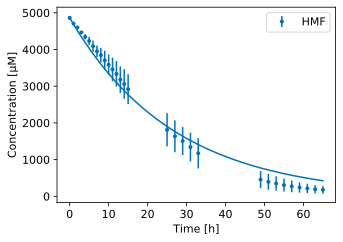

In [10]:
from chemical_kinetics import plot

plot.plot_c(ds, ["HMF"])

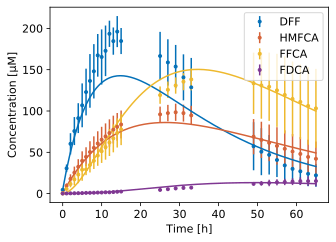

In [11]:
plot.plot_c(ds, ["DFF", "HMFCA", "FFCA", "FDCA"])

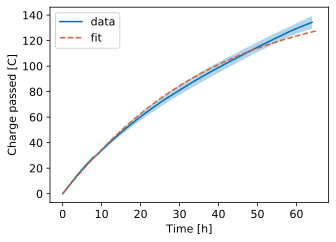

In [12]:
plot.plot_q(ds)